In this Notebook, we'll explore data from Lyft that was provided in the "3d-object-detection-for-autonomous-vehicles" (https://www.kaggle.com/competitions/3d-object-detection-for-autonomous-vehicles/overview) Kaggle competition. Of the two data modalities provided (imagery and lidar point clouds), we will only be using imagery. Our goal is to explore i. Image classification and ii. Object Detection. While I could have chosen data from an origin that had exactly these tasks in mind (MNIST, CIFAR etc), I thought it would make the exploration more difficult and realistic by taking data not already tailored to the use case. 

After some general preprocessing work, we will split our exploration into two phases: Phase 1 will be Image Classification and Phase 2 Will be Object Detection. Within each phase, we will do additional preprocessing steps that are required for the task, and will further break up the phases into sections where we will use pretrained models imported from Pytorch and then try our hand at creating a more simplistic corresponding model by hand.

# Imports and inital data read.

In [2]:
import json
import os
import cv2
from pathlib import Path
from PIL import Image, ImageOps
import pandas as pd
from pandas import json_normalize
import random
import re
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import models
from torchvision.models import resnet50
from torchvision.io import read_image
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# Load the SDK
import lyft_dataset_sdk
from lyft_dataset_sdk.lyftdataset import LyftDataset, LyftDatasetExplorer, Quaternion, view_points
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud
from lyft_dataset_sdk.utils.geometry_utils import BoxVisibility, box_in_image, view_points

In [3]:
data_path = Path(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train")
json_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\data"
lyftdata = LyftDataset(data_path=data_path, json_path=json_path, verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 9.9 seconds.
Reverse indexing ...
Done reverse indexing in 2.7 seconds.


# Data Selection/Preprocessing

## We need to split up the Training data that comes from Lyft into Train and Validatoin data. 

### Because Lyft does not provide ground truth lables for their testing data in their Kaggle competition, we are going to treat the Validation data (taken from the training images and bounding boxes) as our testing data to perform inference on. We randomly split our training and validation data by the date they were recorded. This ensures we control for seasonality of the data and at a minimum ensures that we don't have imagery captures from the same route on the same day.

## Define our custom Dataset class

In [9]:
class Lyft_experimental_CustomDataset(Dataset):
    def __init__(self, cropped_images_dir, target_class_name, required_size=224):
        self.cropped_images_dir = cropped_images_dir
        self.required_size = required_size
        self.image_filenames = os.listdir(cropped_images_dir)
        self.data = []
        #Our class will ingest cropped images from all classes. We must add corresponding labels to these images.
        #The images are stored in directories wrt their class. So, we use the dir name to label the image.
        # Iterate over each subdirectory in the main directory
        for class_name in os.listdir(cropped_images_dir):
            class_dir = os.path.join(cropped_images_dir, class_name)
            if os.path.isdir(class_dir):  # Check if it's a directory
                is_target_class = class_name == target_class_name
                label = 1 if is_target_class else 0

                for filename in os.listdir(class_dir):
                    file_path = os.path.join(class_dir, filename)
                    if os.path.isfile(file_path):  # Check if it's a file
                        self.data.append((file_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path)

        # Convert the image to tensor and normalize
        image = transforms.ToTensor()(image)
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

        return image, label

In [10]:
cropped_images_dir = r'S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\train_cropped_images\224'
dataset = Lyft_experimental_CustomDataset(cropped_images_dir, target_class_name = "pedestrian", required_size=224)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [11]:
for data in dataloader:
    print(data[0])
    print(data[1])
    # print(data[1][0])
    break

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [12]:
for i, data in enumerate(dataloader):
    print(f"Batch {i}: Labels - {data[1]}")
    if i == 10:  # Check first 5 batches
        break

Batch 0: Labels - tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0])
Batch 1: Labels - tensor([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Batch 2: Labels - tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Batch 3: Labels - tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 0])
Batch 4: Labels - tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0])
Batch 5: Labels - tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0])
Batch 6: Labels - tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1])
Batch 7: Labels - tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
for i in range(10):  # Test the first 10 items
    try:
        print(dataset[i])
    except Exception as e:
        print(f"Error at index {i}: {e}")

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -

## Import Pytorch models and train.

In [91]:
model_res50 = models.resnet50(pretrained=True)
num_ftrs = model_res50.fc.in_features
print(num_ftrs)
model_res50.fc = nn.Linear(num_ftrs, 2) # Modify the last layer for binary classification

2048


#### Define loss function

In [92]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_res50.parameters(), lr=0.001)

#### Check if GPU is available and move the model to GPU if it is

In [93]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_res50 = model_res50.to(device)

cuda:0


#### Train through n epochs. In each epoch, we set the model into train mode. 

In [94]:
# Number of epochs to train for
num_epochs = 10

for epoch in range(num_epochs):
    #Set training mode at beginning of each epoch in case we train on validation data within epoch with requires model.eval()
    model_res50.train()  # Set the model to training mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_res50(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataset)
    epoch_acc = running_corrects.double() / len(dataset)

    print(f'Epoch {epoch}/{num_epochs - 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Assuming you have the final loss and accuracy in variables `final_loss` and `final_acc`
    final_loss = 0.0303
    final_acc = 0.9891

    # Save the model state and metrics in a dictionary
    checkpoint = {
        'model_state_dict': model_res50.state_dict(),
        'final_loss': final_loss,
        'final_accuracy': final_acc
    }

    # Save the checkpoint
    torch.save(checkpoint, 'model_res50_checkpoint.pth')

    # To load the model and metrics later
    checkpoint = torch.load('model_res50_checkpoint.pth')
    model_res50.load_state_dict(checkpoint['model_state_dict'])
    loaded_final_loss = checkpoint['final_loss']
    loaded_final_acc = checkpoint['final_accuracy']

Epoch 0/9 Loss: 0.1487 Acc: 0.9397
Epoch 1/9 Loss: 0.1064 Acc: 0.9596
Epoch 2/9 Loss: 0.0903 Acc: 0.9652
Epoch 3/9 Loss: 0.0816 Acc: 0.9682
Epoch 4/9 Loss: 0.0738 Acc: 0.9715
Epoch 5/9 Loss: 0.0649 Acc: 0.9755
Epoch 6/9 Loss: 0.0597 Acc: 0.9779
Epoch 7/9 Loss: 0.0525 Acc: 0.9810
Epoch 8/9 Loss: 0.0484 Acc: 0.9823
Epoch 9/9 Loss: 0.0434 Acc: 0.9833


In [97]:
torch.save(model_res50, r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\models\resnet50_2023_11_21_22_15")

## Load the model we trained back into our Notbook after previously saving it.

In [101]:
model_res50 = torch.load(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\models\resnet50_2023_11_21_22_15")
model_res50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [102]:
for name, layer in model_res50.named_modules():
    if isinstance(layer, nn.Conv2d):
        print(f"Layer: {name} | Kernel Size: {layer.kernel_size} | Output Channels: {layer.out_channels}")

Layer: conv1 | Kernel Size: (7, 7) | Output Channels: 64
Layer: layer1.0.conv1 | Kernel Size: (1, 1) | Output Channels: 64
Layer: layer1.0.conv2 | Kernel Size: (3, 3) | Output Channels: 64
Layer: layer1.0.conv3 | Kernel Size: (1, 1) | Output Channels: 256
Layer: layer1.0.downsample.0 | Kernel Size: (1, 1) | Output Channels: 256
Layer: layer1.1.conv1 | Kernel Size: (1, 1) | Output Channels: 64
Layer: layer1.1.conv2 | Kernel Size: (3, 3) | Output Channels: 64
Layer: layer1.1.conv3 | Kernel Size: (1, 1) | Output Channels: 256
Layer: layer1.2.conv1 | Kernel Size: (1, 1) | Output Channels: 64
Layer: layer1.2.conv2 | Kernel Size: (3, 3) | Output Channels: 64
Layer: layer1.2.conv3 | Kernel Size: (1, 1) | Output Channels: 256
Layer: layer2.0.conv1 | Kernel Size: (1, 1) | Output Channels: 128
Layer: layer2.0.conv2 | Kernel Size: (3, 3) | Output Channels: 128
Layer: layer2.0.conv3 | Kernel Size: (1, 1) | Output Channels: 512
Layer: layer2.0.downsample.0 | Kernel Size: (1, 1) | Output Channels: 5

### Visualize the output of the first layer which is a convolution layer with kernel 7x7. This is just to remind us what we are dealing with.

tensor([[[0.4760, 0.4743, 0.4661, 0.4955, 0.5031, 0.4722, 0.4078],
         [0.4549, 0.4583, 0.4736, 0.5090, 0.5175, 0.4930, 0.4511],
         [0.4549, 0.4578, 0.4556, 0.5131, 0.5559, 0.5352, 0.5052],
         [0.4458, 0.4449, 0.4122, 0.4309, 0.4550, 0.4880, 0.4916],
         [0.4411, 0.4677, 0.4452, 0.4304, 0.3853, 0.4004, 0.4419],
         [0.4417, 0.4869, 0.4927, 0.5223, 0.4753, 0.4100, 0.4144],
         [0.4181, 0.4639, 0.4738, 0.5290, 0.5222, 0.4761, 0.4490]],

        [[0.4667, 0.4824, 0.4985, 0.5539, 0.5650, 0.5308, 0.4546],
         [0.4587, 0.4801, 0.5151, 0.5860, 0.6175, 0.5998, 0.5558],
         [0.4292, 0.4116, 0.4039, 0.4862, 0.5737, 0.6037, 0.5906],
         [0.4195, 0.3754, 0.2920, 0.2714, 0.3157, 0.4213, 0.4813],
         [0.4701, 0.4662, 0.4027, 0.3180, 0.2336, 0.2634, 0.3562],
         [0.4962, 0.5463, 0.5501, 0.5535, 0.4620, 0.3612, 0.3520],
         [0.4673, 0.5338, 0.5726, 0.6424, 0.6185, 0.5381, 0.4710]],

        [[0.4642, 0.4702, 0.4877, 0.5323, 0.5415, 0.5142, 

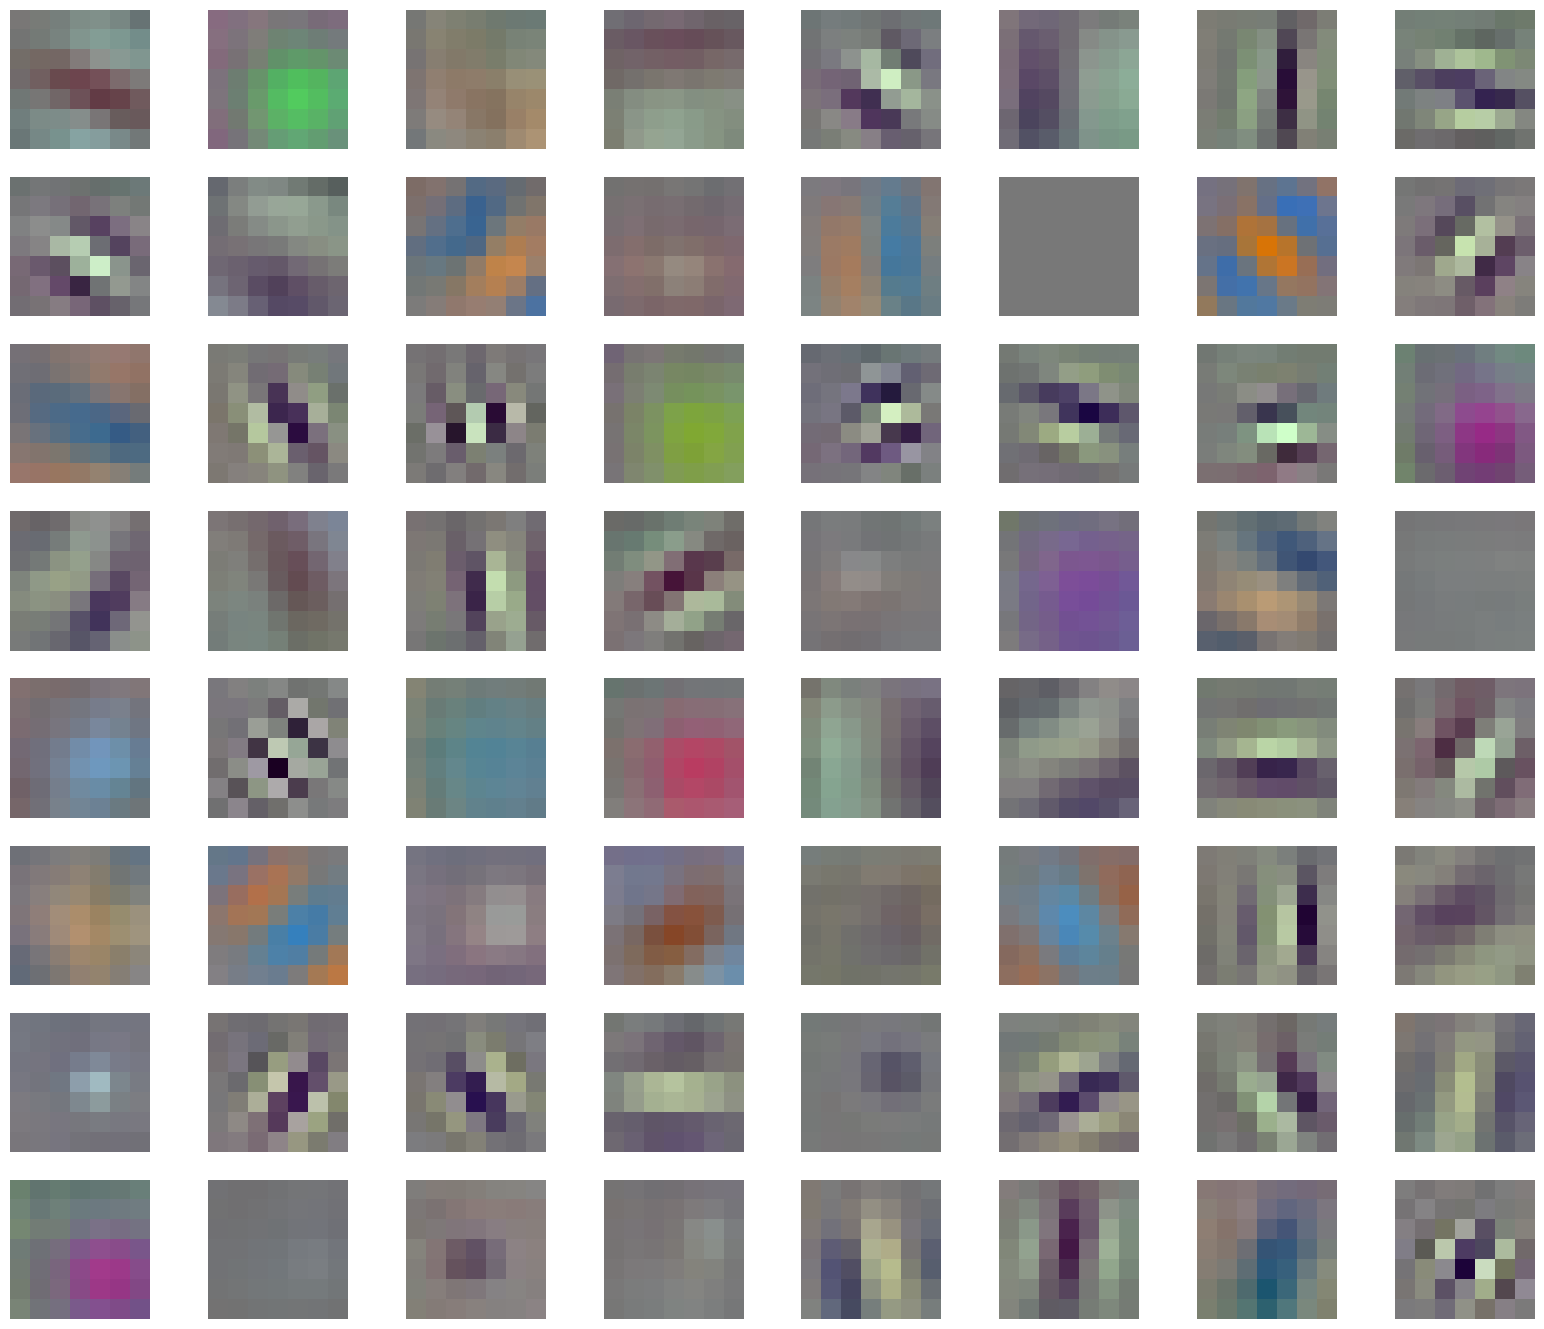

In [103]:
# Ensure it's in evaluation mode for visualization
model_res50.eval()  # This changes the model to evaluation mode

# Get the weights of the first convolutional layer
weights = model_res50.conv1.weight.data.cpu()

# Normalize the weights for better visualization
weights = (weights - weights.min()) / (weights.max() - weights.min())
print(weights[0])
print(weights[0].permute(1, 2, 0))
# Plot the first few filters
plt.figure(figsize=(20, 17))
for i in range(64):  # Let's visualize 64 filters
    plt.subplot(8, 8, i + 1)
    plt.imshow(weights[i].permute(1, 2, 0))  # Rearrange the dimensions
    plt.axis('off')
plt.show()

## Inference 1: Shrunken image input

In [108]:
validation_images_dir = r'S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\validation_cropped_images\224'
dataset_validation = Lyft_experimental_CustomDataset(validation_images_dir, target_class_name = "pedestrian", required_size=224)
dataloader_validation = DataLoader(dataset, batch_size=32, shuffle=True)

In [109]:
# sizes = [224]
# dynamic_transform(validation_images_dir, sizes)

In [19]:
# window_size = 224
#Our test data/images will be preselected to only data that we know contains at least one instance of the target class.
#Additionally, we will only account for preexisting bounding boxes that are also of the target class. This simplifies the initial task, and can be expanded to include non-target class boxes for additional testing in the future.
#test_data will be of the form below which is a dictionaries with key as the img_id_name and the value as a list of 1:n dictionaries where each dictionary has two elements for the original and predicted bounding box whose
#values are simply the coordinates of the bounding box in image coordinates.
#Remember: All of our bounding_box_original boxes will be from the set of only the boxes of the target class.
#test_data = {img_id_name: [{bounding_box_original: np.array(), bounding_box_predicted: np.array()},
#                       {bounding_box_original: np.array(), bounding_box_predicted: np.array()}]}

# for img_id_name, box_list in test_data:
    #split up the image into "window_size" subsections. Input windows are 1024x1224, so window size of 224 will not split evenly. How to handle non-even splits for convolution/sliding windows?
    #for each subsection:
        #feed the subsection into my network and get a binary prediction: 1 - yes, this is the target class (pedestrain) or 0, no this is not the target class.

        #if we found a target class:
            #target_box = coordinates of the image that pertain to subsection that has a positive prediction
            

IndentationError: expected an indented block (1927823325.py, line 2)

In [110]:
# Set the model to evaluation mode
model_res50.eval()

running_loss = 0.0
running_corrects = 0
total_samples = 0

# Disable gradient calculations as they are not needed for validation
with torch.no_grad():
    for inputs, labels in dataloader_validation:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_res50(inputs)
        loss = criterion(outputs, labels)

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

# Calculate the average loss and accuracy over the validation set
val_loss = running_loss / total_samples
val_acc = running_corrects.double() / total_samples

print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

Validation Loss: 0.0389 Acc: 0.9868


In [111]:
checkpoint = {
    'model_state_dict': model_res50.state_dict(),
    'validation_loss': val_loss,
    'validation_accuracy': val_acc
}

# Save the checkpoint
torch.save(checkpoint, 'model_res50_validation_checkpoint.pth')

## Inference 2: Whole image input

### In order to do inference of whole images with our model that was trained on shrunken images, we need to do additional processing steps.

### Heatmap. Note: We use both training and validation data to aggregate a heat map. The heat map itelf isn't involved as a parameter in the model. This is simply just using a greater sample size to determine the places within the full sized images that are least likely for pedestrians to occur.

In [13]:
#Get all bounding boxes for pedestrians.
pedestrian_images_boxes = img_category_train_val_split("pedestrian", lyftdata, train_validation_log_tokens= [train_logs_tokens, validation_logs_tokens])
pedestrian_images_boxes[0]

[('S:\\MADS\\Capstone\\3d-object-detection-for-autonomous-vehicles\\Train\\images\\host-a101_cam4_1241893247216660006.jpeg',
  label: nan, score: nan, xyz: [-2.88, 0.63, 10.40], wlh: [0.58, 0.75, 1.65], rot axis: [-0.93, -0.28, 0.25], ang(degrees): -94.52, ang(rad): -1.65, vel: nan, nan, nan, name: pedestrian, token: 54bcef056e51c83ff6929c85949835ab8250f6557c4d9a98c2f1218158b51dad,
  array([[1.11019631e+03, 0.00000000e+00, 9.56342543e+02],
         [0.00000000e+00, 1.11019631e+03, 5.38552500e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'c92f301f36511814c7ba5f5530bc70d76192748e5393946c33e609f32a8d2388',
  'CAM_BACK_LEFT',
  '54bcef056e51c83ff6929c85949835ab8250f6557c4d9a98c2f1218158b51dad'),
 ('S:\\MADS\\Capstone\\3d-object-detection-for-autonomous-vehicles\\Train\\images\\host-a101_cam0_1241893247250000006.jpeg',
  label: nan, score: nan, xyz: [14.36, 2.77, 90.38], wlh: [0.98, 0.90, 2.00], rot axis: [0.57, -0.58, 0.59], ang(degrees): 119.05, ang(rad): 2.08, vel:

In [17]:
pedestrian_training_boxes = pedestrian_images_boxes[0]
pedestrian_validation_boxes = pedestrian_images_boxes[1]

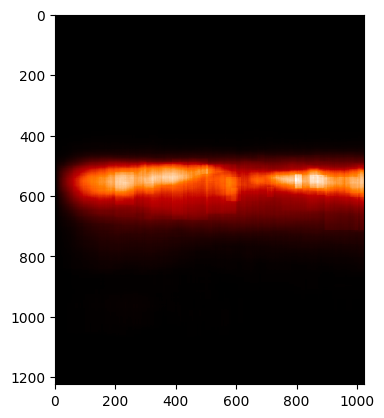

In [21]:
# Initialize heatmap grid
heatmap = np.zeros((1224, 1024))

for tup in pedestrian_training_boxes:
    path, box, camera_intrinsic, sample_token, cam, ann = tup
    
    box_coords = view_points(box.corners(), view = camera_intrinsic, normalize=True)[:2, :]
    
    # Calculate bounding box coordinates and round to nearest integer
    x_min = int(np.round(np.min(box_coords[0])))
    y_min = int(np.round(np.min(box_coords[1])))
    x_max = int(np.round(np.max(box_coords[0])))
    y_max = int(np.round(np.max(box_coords[1])))

    # Adjust if the coordinates are outside the image
    x_min = max(x_min, 0)
    y_min = max(y_min, 0)
    x_max = min(x_max, heatmap.shape[1] - 1)
    y_max = min(y_max, heatmap.shape[0] - 1)

    heatmap[y_min:y_max, x_min:x_max] += 1

for tup in pedestrian_validation_boxes:
    path, box, camera_intrinsic, sample_token, cam, ann = tup

    box_coords = view_points(box.corners(), view = camera_intrinsic, normalize=True)[:2, :]

    # Calculate bounding box coordinates and round to nearest integer
    x_min = int(np.round(np.min(box_coords[0])))
    y_min = int(np.round(np.min(box_coords[1])))
    x_max = int(np.round(np.max(box_coords[0])))
    y_max = int(np.round(np.max(box_coords[1])))

    # Adjust if the coordinates are outside the image
    x_min = max(x_min, 0)
    y_min = max(y_min, 0)
    x_max = min(x_max, heatmap.shape[1] - 1)
    y_max = min(y_max, heatmap.shape[0] - 1)

    heatmap[y_min:y_max, x_min:x_max] += 1

# Normalize the heatmap
heatmap = heatmap / np.max(heatmap)

# Plot the heatmap
plt.imshow(heatmap, cmap='gist_heat', interpolation='nearest')
plt.show()

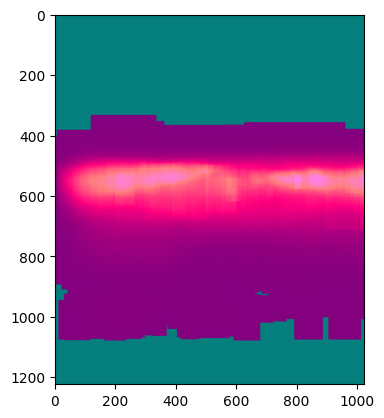

In [33]:
# Create a mask for any non-zero values
outlier_mask = heatmap > 0

# Plot the heatmap with non-zero values highlighted
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.imshow(outlier_mask, cmap='cool', alpha=0.5) # overlaying with a different color
plt.show()